# Calculate Daily Average PET From WRF-Derived Variables
## Lejo Flores
## 2021-04-25

This workbook i

Uses FAO 56

PET = 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

wrf_output_dir = '/Volumes/G-SPEED Shuttle XL/wrf-30yr-daily/'
wrf_landmodel_file = wrf_output_dir+'landmodel/wy2017/landmodel_d01_2017-06-15_daily_summary.nc'
wrf_forcing_file = wrf_output_dir+'forcing/wy2017/forcing_d01_2017-06-15_daily_summary.nc'
wrf_surfrad_file = wrf_output_dir+'surfrad/wy2017/surfrad_d01_2017-06-15_daily_summary.nc'

In [2]:
ds_land = xr.open_dataset(wrf_landmodel_file)
ds_atmo = xr.open_dataset(wrf_forcing_file)
ds_surfrad = xr.open_dataset(wrf_surfrad_file)

In [3]:
print(ds_land)
print(ds_atmo)
print(ds_surfrad)

<xarray.Dataset>
Dimensions:    (XTIME: 1, soil_layers_stag: 4, south_north: 289, west_east: 339)
Coordinates:
  * XTIME      (XTIME) datetime64[ns] 2017-06-15
Dimensions without coordinates: soil_layers_stag, south_north, west_east
Data variables:
    XLAT       (XTIME, south_north, west_east) float32 ...
    XLONG      (XTIME, south_north, west_east) float32 ...
    SMOIS_DM   (XTIME, soil_layers_stag, south_north, west_east) float32 ...
    SFROFF_DV  (XTIME, south_north, west_east) float32 ...
    SNOW_DM    (XTIME, south_north, west_east) float32 ...
    SNOWH_DM   (XTIME, south_north, west_east) float32 ...
    TSLB_DM    (XTIME, soil_layers_stag, south_north, west_east) float32 ...
    LH_DM      (XTIME, south_north, west_east) float32 ...
    GHV_DM     (XTIME, south_north, west_east) float32 ...
    GHB_DM     (XTIME, south_north, west_east) float32 ...
    EVG_DM     (XTIME, south_north, west_east) float32 ...
    EVB_DM     (XTIME, south_north, west_east) float32 ...
    SHG

In [4]:
# Get variables needed to compute PET
U = np.squeeze(ds_atmo['U10_DM'].values) # Zonal wind at 10 m, daily average
V = np.squeeze(ds_atmo['V10_DM'].values) # Meridional wind at 10 m, daily average
T2 = np.squeeze(ds_atmo['T2_DV'].values) # Temperature at 2 m, daily average
Q2 = np.squeeze(ds_atmo['Q2_DM'].values) # Specific humidity at 2 m, daily average
P = np.squeeze(ds_atmo['PSFC_DM'].values) # Surface pressure, daily average

# Get the radiant fluxes
SWdown = np.squeeze(ds_surfrad['SWDOWN_DM'].values)
SWup = np.squeeze(ds_surfrad['SWUPB_DM'].values)
LWdown = np.squeeze(ds_surfrad['GLW_DM'].values)
LWup = np.squeeze(ds_surfrad['LWUPB_DM'].values)

# Get the ground heat flux
Gveg = np.squeeze(ds_land['GHV_DM'].values)
Gsoi = np.squeeze(ds_land['GHB_DM'].values)
Fv = np.squeeze(ds_land['FVEG_DM'].values)

# Get latent heat flux from the model
LH = np.squeeze(ds_land['LH_DM'].values)

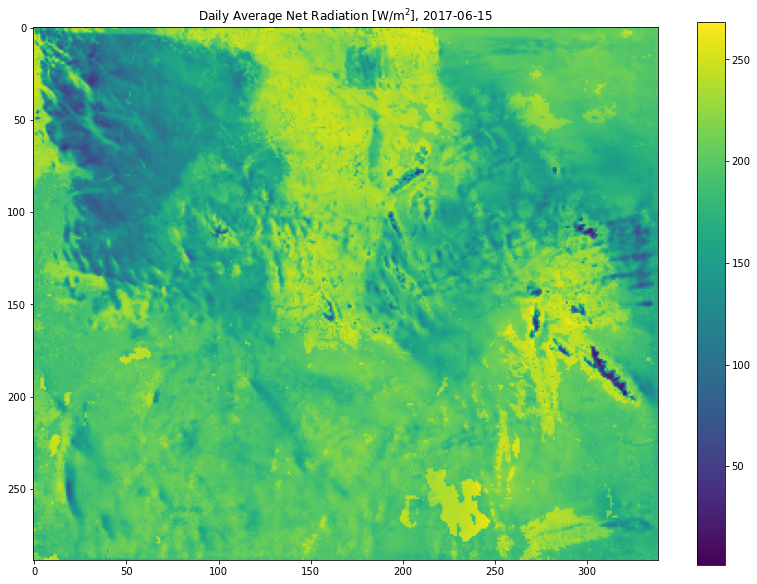

In [5]:
# Calculate the net radiation
Rnet = ((SWdown - SWup) + (LWdown - LWup))

# Plot Rnet to verify appropriate range
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(Rnet))
plt.title('Daily Average Net Radiation [W/m${}^2$], 2017-06-15')
plt.colorbar()

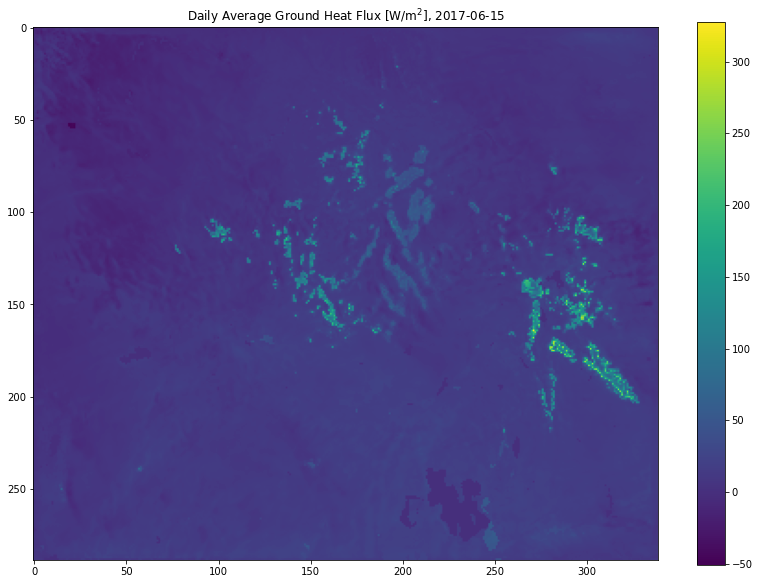

In [6]:
# Calculate the ground heat flux by multiplying the ground heat flux under canopy 
# by the vegetation fraction and adding the ground heat flux of bare soil times  
# one minus the vegetation fraction
G = Gveg * Fv + (1.0 - Fv) * Gsoi

# Plot G to verify appropriate range and direction
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(G))
plt.title('Daily Average Ground Heat Flux [W/m${}^2$], 2017-06-15')
plt.colorbar()

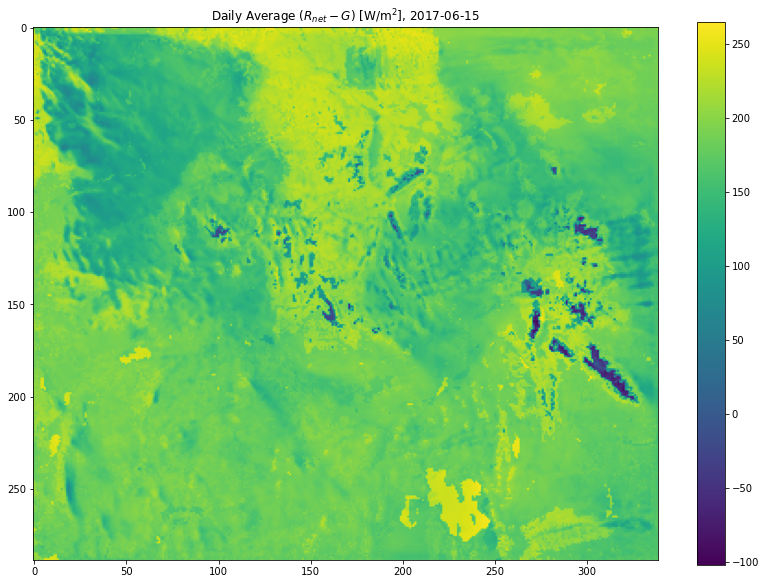

In [7]:
# Plot (Rn - G) to verify appropriate range and direction
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(Rnet - G))
plt.title('Daily Average $(R_{net} - G)$ [W/m${}^2$], 2017-06-15')
plt.colorbar()

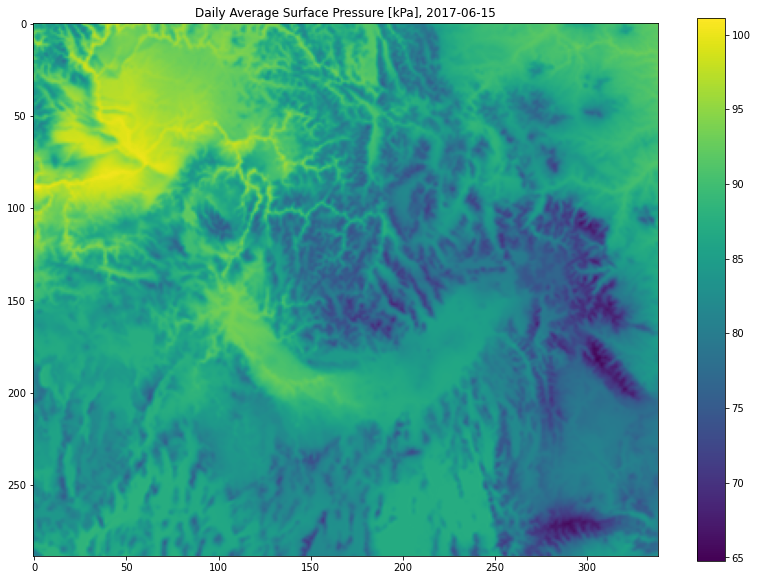

In [8]:
# Plot surface pressure to verify appropriate range and direction

P = P / 1000.0 # Convert from Pa to kPa

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(P))
plt.title('Daily Average Surface Pressure [kPa], 2017-06-15')
plt.colorbar()

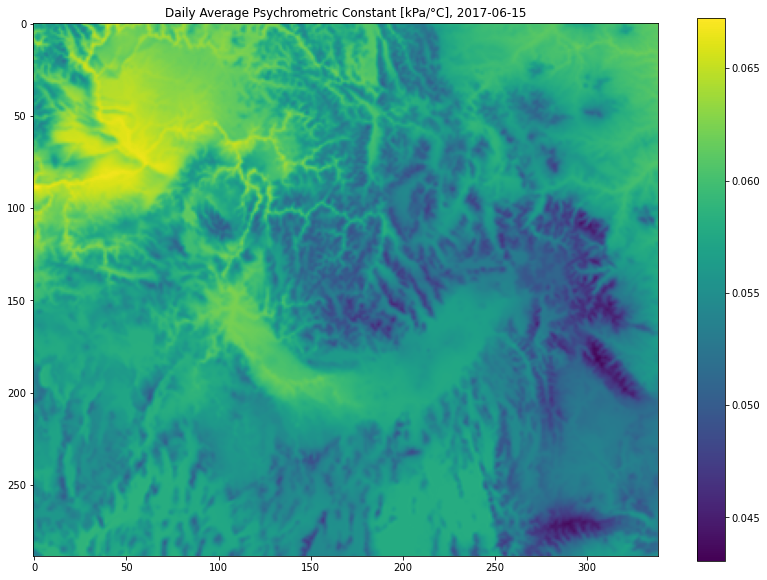

In [9]:
# Compute the Psychrometric Constant (γ)

γ = 0.665E-03 * P

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(γ))
plt.title('Daily Average Psychrometric Constant [kPa/°C], 2017-06-15')
plt.colorbar()

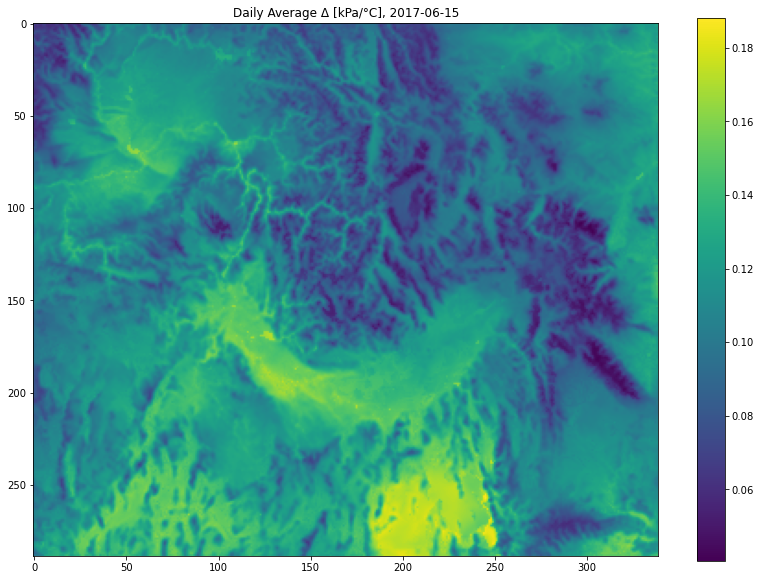

In [10]:
T2C = T2 - 273.15

Δ = (2504.0 * np.exp((17.27*T2C)/(T2C + 237.2)))/ (T2C + 237.2)**2.0

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(Δ))
plt.title('Daily Average Δ [kPa/°C], 2017-06-15')
plt.colorbar()

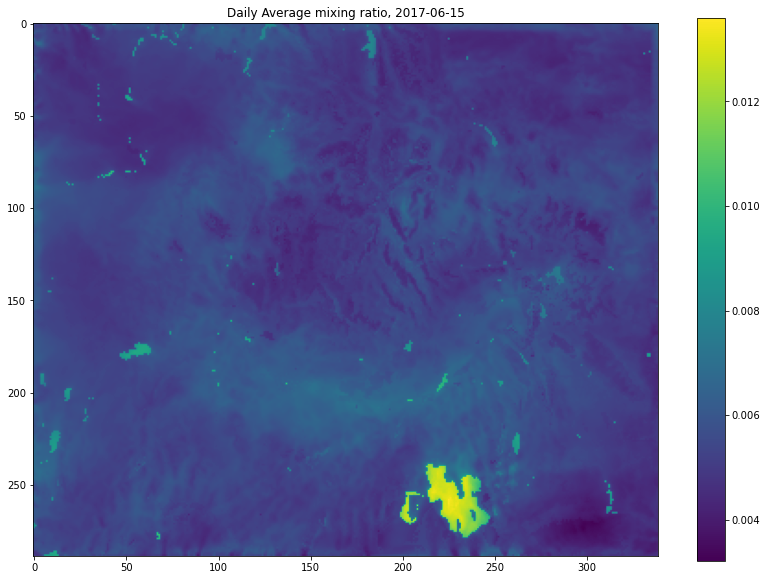

In [11]:
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(Q2))
plt.title('Daily Average mixing ratio, 2017-06-15')
plt.colorbar()

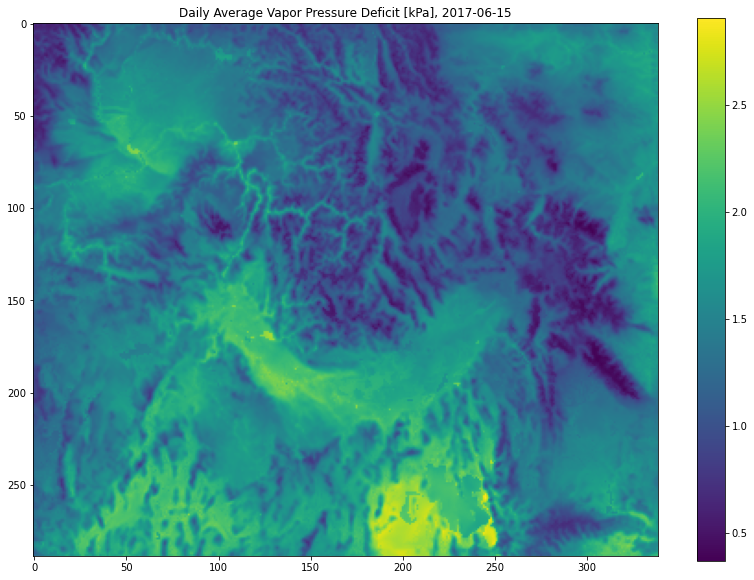

In [12]:
# Calculate saturation and actual vapor pressure, and vapor pressure deficit
ea = 0.622 * P * Q2 # Vapor pressure in kPa
es = 0.611 * np.exp((17.27*T2C)/(T2C + 237.2)) # Saturation vapor pressure in kPa

VPD = (es - ea)

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(VPD))
plt.title('Daily Average Vapor Pressure Deficit [kPa], 2017-06-15')
plt.colorbar()


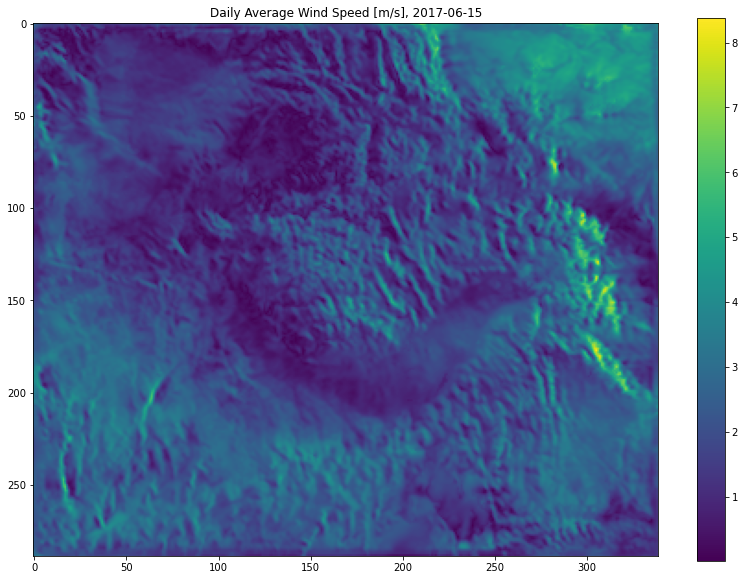

In [13]:
# Calculate wind speed 
U10 = np.sqrt(U**2.0 + V**2.0) * 0.75

U2 = U10 * 4.87 / np.log(67.8*10.0 - 5.42)

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(U2))
plt.title('Daily Average Wind Speed [m/s], 2017-06-15')
plt.colorbar()


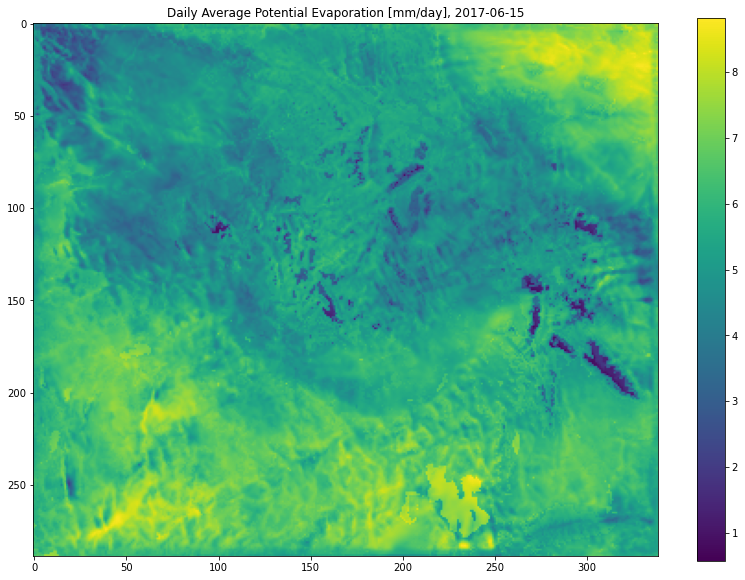

In [14]:
# Calculate Potential Evapotranspiration

# Note the multiplication of (Rn - G) by 0.0864 to convert from W/m^2 to MJ/m^2/day

PETnum = 0.408 * Δ * ((Rnet - G) * 0.0864) + (γ * U2 * VPD) * (900.0 / (T2C + 273.0))
PETden = Δ + γ*(1 + 0.34*U2)

PET = PETnum / PETden

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(PET))
plt.title('Daily Average Potential Evaporation [mm/day], 2017-06-15')
plt.colorbar()


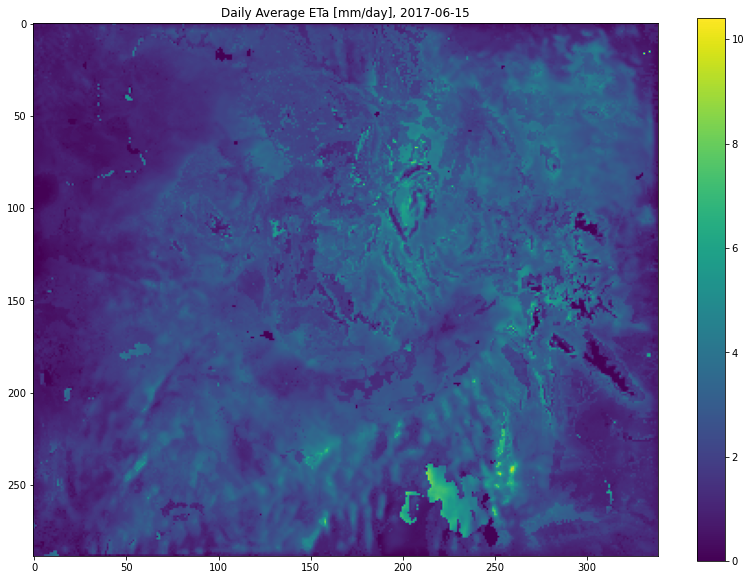

In [15]:
ETa = LH * (1.0/2.5E6) * (86400.0)

plt.figure(figsize=(14,10))
plt.imshow(np.flipud(ETa))
plt.title('Daily Average ETa [mm/day], 2017-06-15')
plt.colorbar()


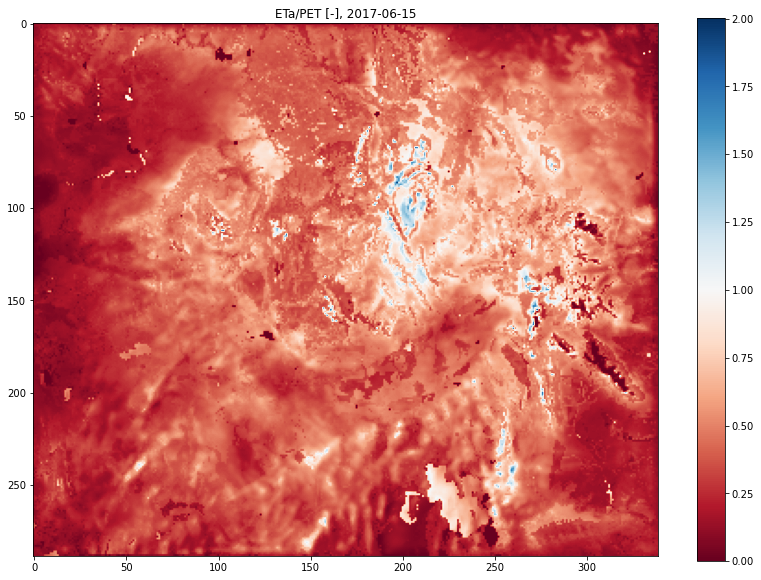

In [21]:
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(ETa/PET),cmap='RdBu')
plt.title('ETa/PET [-], 2017-06-15')
plt.colorbar()
